In [29]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import data_utils

RUN_FOLDER_KCM = "../results/debug/kcm/"
RUN_FOLDER_ATB = "../results/debug/atb/"
RUN_FOLDER_MIX = "../results/debug/kcm_atb/"
RUN_FOLDER_RUT = "../results/debug/rut/"

In [ ]:
# Hyperparam results per network:
# CONV (128, 64, 3, 0.1)
# FF (128, 128, 2, 0.2)
# GRU (128, 64, 2, 0.05)
# TRSF (128, 64, 3, 0.1)

# KCM
# 512, 16, 2, 0.4 (TRSF)
# 512, 16, 5, 0.1
# 512, 128, 4, 0.4
# 128, 128, 2, 0.2 (FF)
# 128, 128, 2, 0.05 (GRU, CONV)
# 512, 16, 4, 0.2
# 1024, 16, 4, 0.1

# Model Epochs TestLoss
# CONV_0	10.000000	18.066327
# FF_0	11.333333	168.559759
# GRU_0	16.000000	18.540478
# TRSF_0	10.000000	22.919503

# CONV_0	10.000000	17.851481
# FF_0	11.333333	157.528422
# GRU_0	10.000000	22.917446
# TRSF_0	10.000000	22.915722

# CONV_0	12.0	15.852690
# FF_0	14.0	153.020960
# GRU_0	10.0	22.916604
# TRSF_0	10.0	22.912308

# CONV_0	12.8	15.829175
# FF_0	38.8	137.929590
# GRU_0	10.0	16.677470
# TRSF_0	10.0	22.853009

# CONV_1	12.8	15.750058
# FF_1	38.0	138.345676
# GRU_1	10.0	16.506545
# TRSF_1	10.0	22.851783

# CONV_0	10.0	17.629307
# FF_0	11.0	158.601257
# GRU_0	10.0	22.885823
# TRSF_0	10.0	22.888074

# CONV_1	10.0	18.191666
# FF_1	13.0	157.479233
# GRU_1	10.0	22.871649
# TRSF_1	10.0	22.862472


# AtB
# 512, 32, 3, 0.2
# 512, 32, 5, 0.4
# 512, 16, 2, 0.4
# 128, 32, 4, 0.2
# 128, 64, 5, 0.05 (CONV, FF, GRU, TRSF)

# CONV_0	12.666667	7.069618
# FF_0	19.333333	63.465285
# GRU_0	17.333333	9.175895
# TRSF_0	16.000000	9.075986

# CONV_0	12.000000	6.991179
# FF_0	18.000000	67.876277
# GRU_0	16.666667	9.161330
# TRSF_0	20.000000	9.001094

# CONV_0	14.000000	7.567914
# FF_0	23.333333	66.901993
# GRU_0	20.000000	9.058873
# TRSF_0	16.000000	9.404305

# CONV_0	10.8	6.135663
# FF_0	17.2	63.238688
# GRU_0	11.6	8.897823
# TRSF_0	11.6	8.895937

# CONV_1	10.0	6.058242
# FF_1	19.2	60.404724
# GRU_1	10.0	8.898676
# TRSF_1	10.8	8.893464

In [43]:
# Load results from the training script
kcm_training_results = data_utils.load_pkl(f"{RUN_FOLDER_KCM}model_results.pkl")
kcm_result_df, kcm_time_df = data_utils.extract_results(kcm_training_results, "Seattle")
# Load curves from lightning
kcm_model_results = data_utils.extract_lightning_results(f"{RUN_FOLDER_KCM}logs/", "Seattle")
# Load results from experiments script
kcm_gen_results = data_utils.load_pkl(RUN_FOLDER_KCM + "model_generalization_results.pkl")
kcm_gen_df = data_utils.extract_gen_results("Seattle", kcm_gen_results)

# Load results from the training script
atb_training_results = data_utils.load_pkl(f"{RUN_FOLDER_ATB}model_results.pkl")
atb_result_df, atb_time_df = data_utils.extract_results(atb_training_results, "Trondheim")
# Load curves from lightning
atb_model_results = data_utils.extract_lightning_results(f"{RUN_FOLDER_ATB}logs/", "Trondheim")
# Load results from experiments script
atb_gen_results = data_utils.load_pkl(RUN_FOLDER_ATB + "model_generalization_results.pkl")
atb_gen_df = data_utils.extract_gen_results("Trondheim", atb_gen_results)

In [52]:
# Model training and validation curves
kcm_model_curves = kcm_model_results[kcm_model_results["Loss Set"].isin(["Train","Valid"])]
atb_model_curves = atb_model_results[atb_model_results["Loss Set"].isin(["Train","Valid"])]
model_curves_df = pd.concat([kcm_model_curves, atb_model_curves])

In [45]:
# Baselines for comparing between original evaluation and generalization
kcm_baseline_df = kcm_gen_df[kcm_gen_df['Loss']=="Train_Losses"].copy()
kcm_baseline_df['Loss'] = "Network Baseline"
kcm_baseline_df = kcm_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]
kcm_deterioration_df = kcm_gen_df[kcm_gen_df['Loss'].isin(['Tune_Train_Losses'])].copy()

atb_baseline_df = atb_gen_df[atb_gen_df['Loss']=="Train_Losses"].copy()
atb_baseline_df['Loss'] = "Network Baseline"
atb_baseline_df = atb_baseline_df[['Model','City','Loss','Fold','MAPE','RMSE','MAE']]
atb_deterioration_df = atb_gen_df[atb_gen_df['Loss'].isin(['Tune_Train_Losses'])].copy()

In [33]:
print(f"All Unique Models: {pd.unique(kcm_gen_df['Model'])}")

All Unique Models: ['FF' 'CONV' 'GRU' 'TRSF' 'DEEP_TTE']


### Model Performance

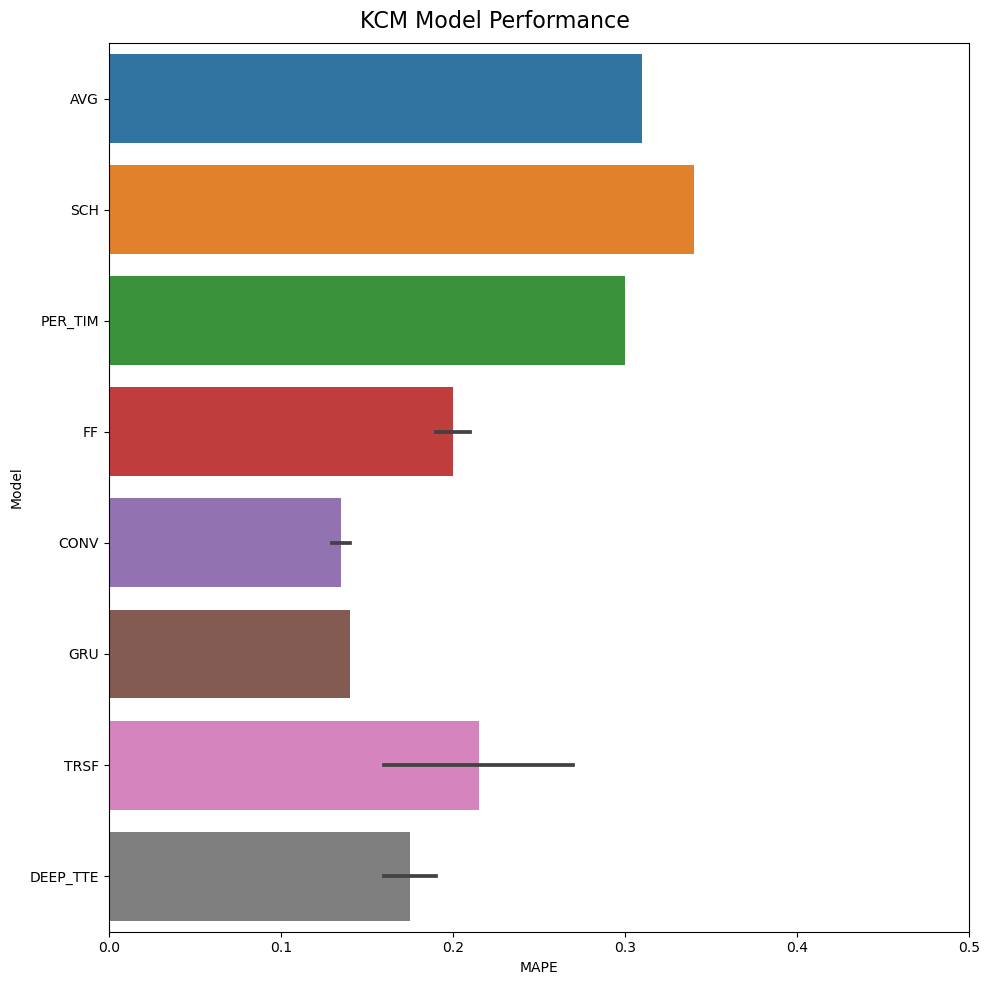

In [39]:
plot_data = kcm_result_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes)
axes.set_xlim([0, 0.5])
fig.suptitle('KCM Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_kcm.png", dpi=1800, bbox_inches='tight')

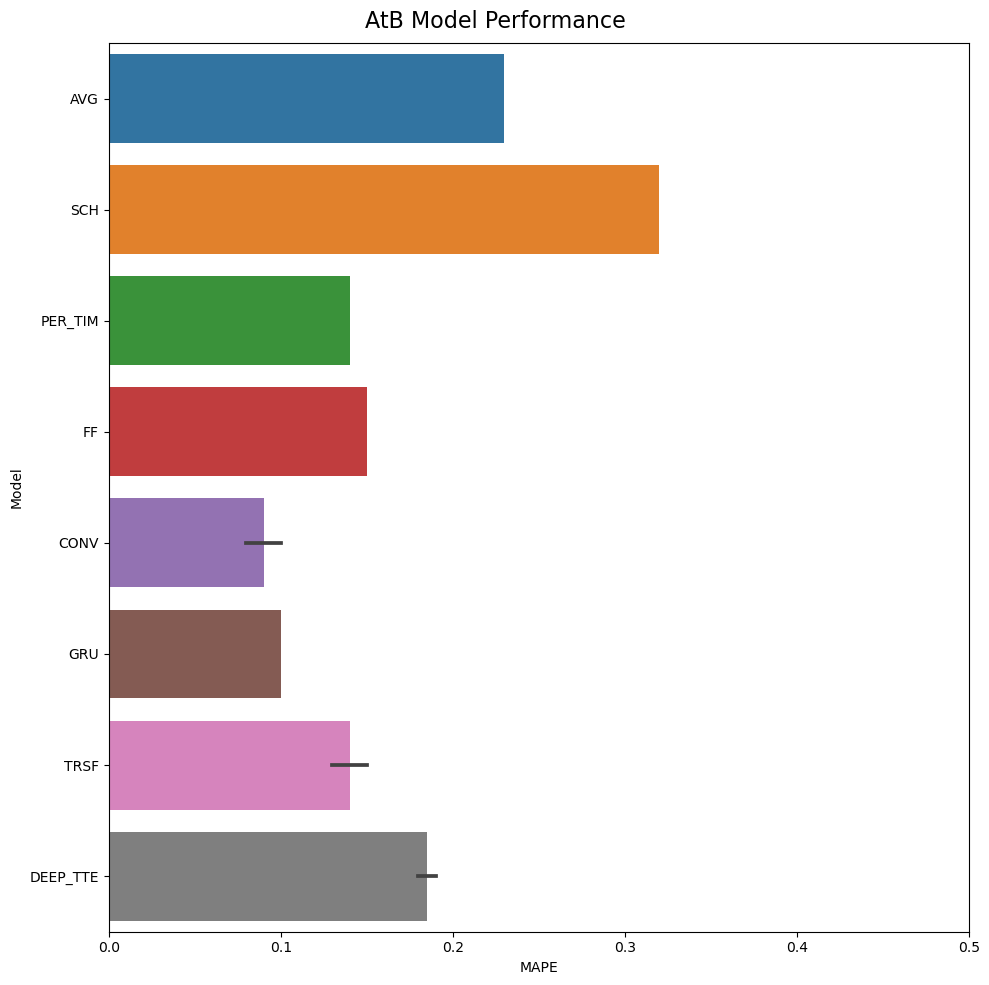

In [40]:
plot_data = atb_result_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes)
axes.set_xlim([0, 0.5])
fig.suptitle('AtB Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_atb.png", dpi=1800, bbox_inches='tight')

### Training Time

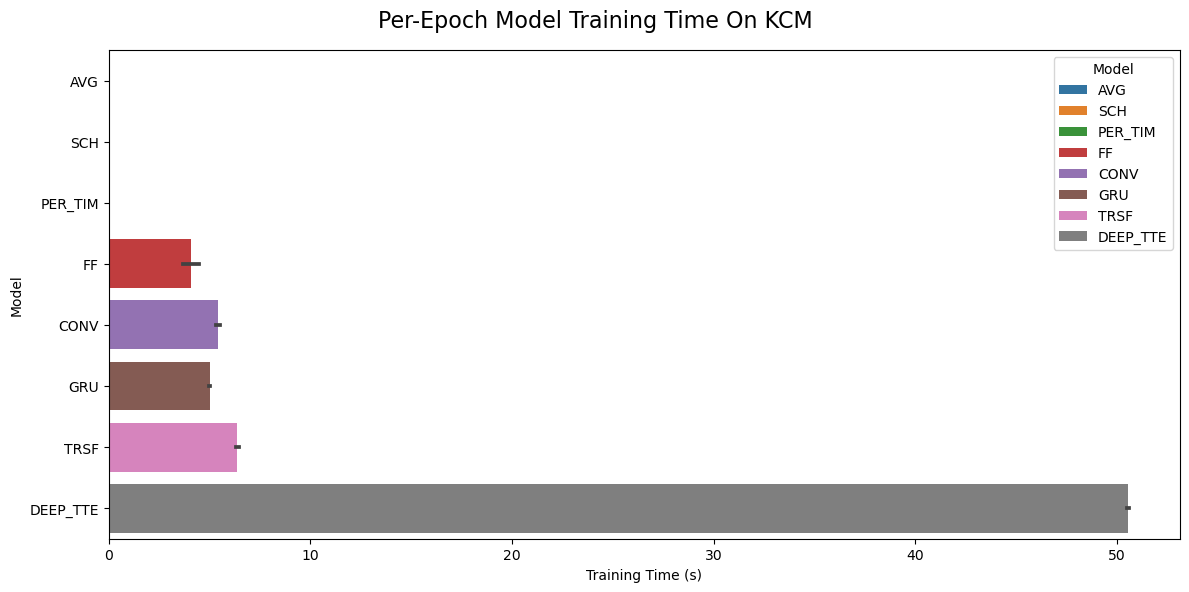

In [46]:
plot_data = kcm_time_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(12)
sns.barplot(plot_data, x="Time", y="Model", hue="Model", dodge=False)
axes.set_ylabel("Model")
axes.set_xlabel("Training Time (s)")
fig.suptitle('Per-Fold Model Training Time On KCM', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_train_time_kcm.png", dpi=1800, bbox_inches='tight')

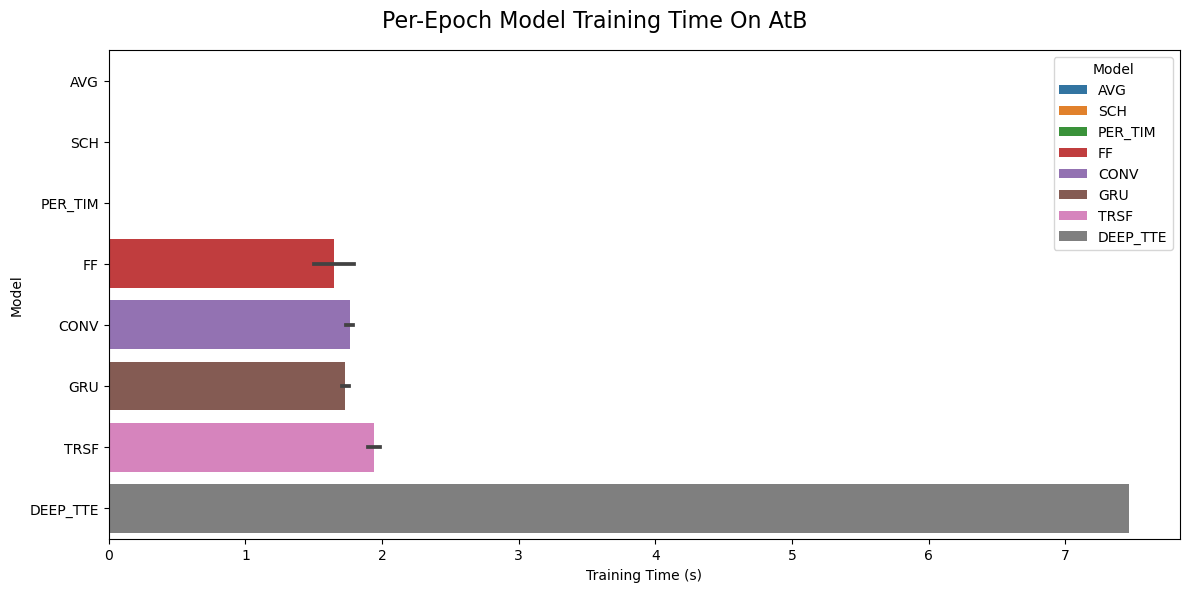

In [47]:
plot_data = atb_time_df
fig, axes = plt.subplots(1,1)
fig.set_figheight(6)
fig.set_figwidth(12)
sns.barplot(plot_data, x="Time", y="Model", hue="Model", dodge=False)
axes.set_ylabel("Model")
axes.set_xlabel("Training Time (s)")
fig.suptitle('Per-Fold Model Training Time On AtB', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_train_time_atb.png", dpi=1800, bbox_inches='tight')

### Training Curves

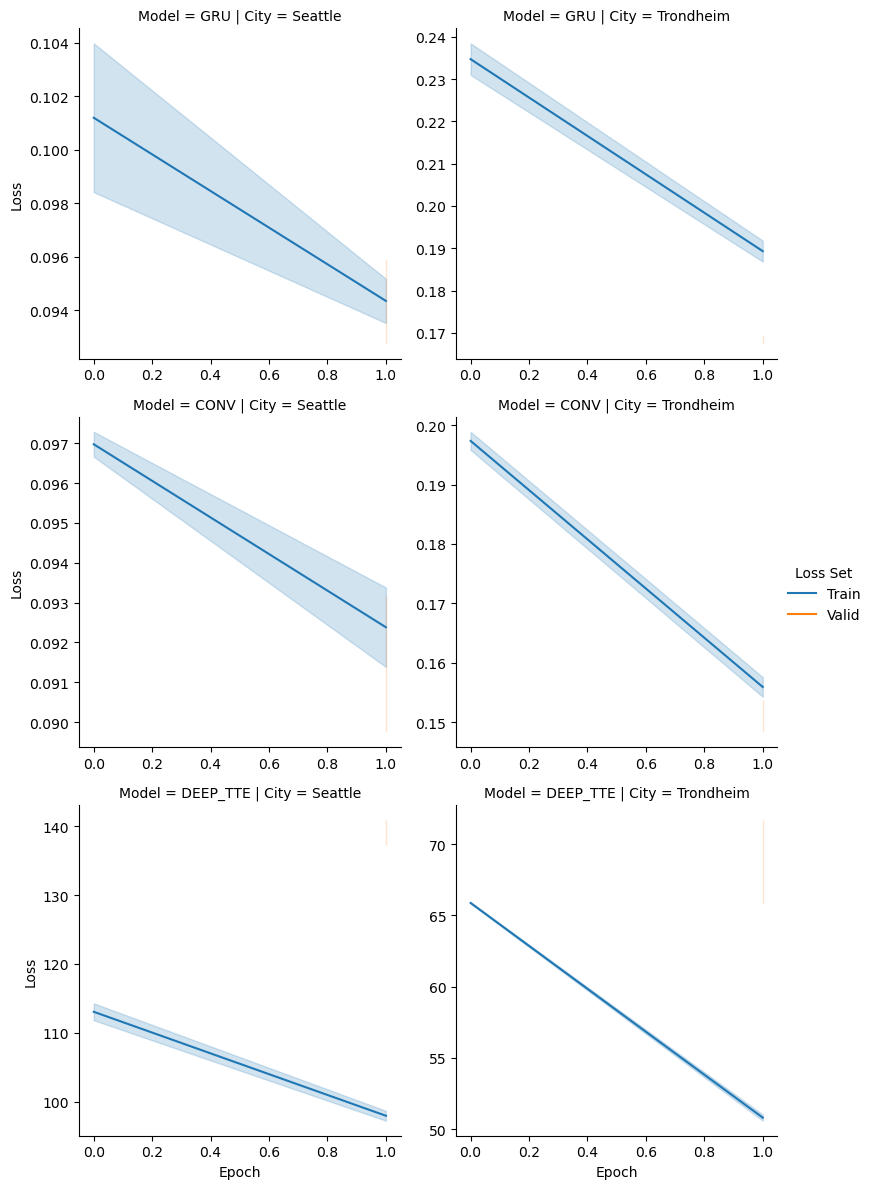

In [53]:
model_list = pd.unique(model_curves_df['Model'])
plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[:3])]
g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Valid"], height=4, sharex=False, sharey=False)
g.map(sns.lineplot, "Epoch", "Loss")
g.add_legend()
plt.savefig(f"../plots/model_curves_1.png", dpi=1800, bbox_inches='tight')

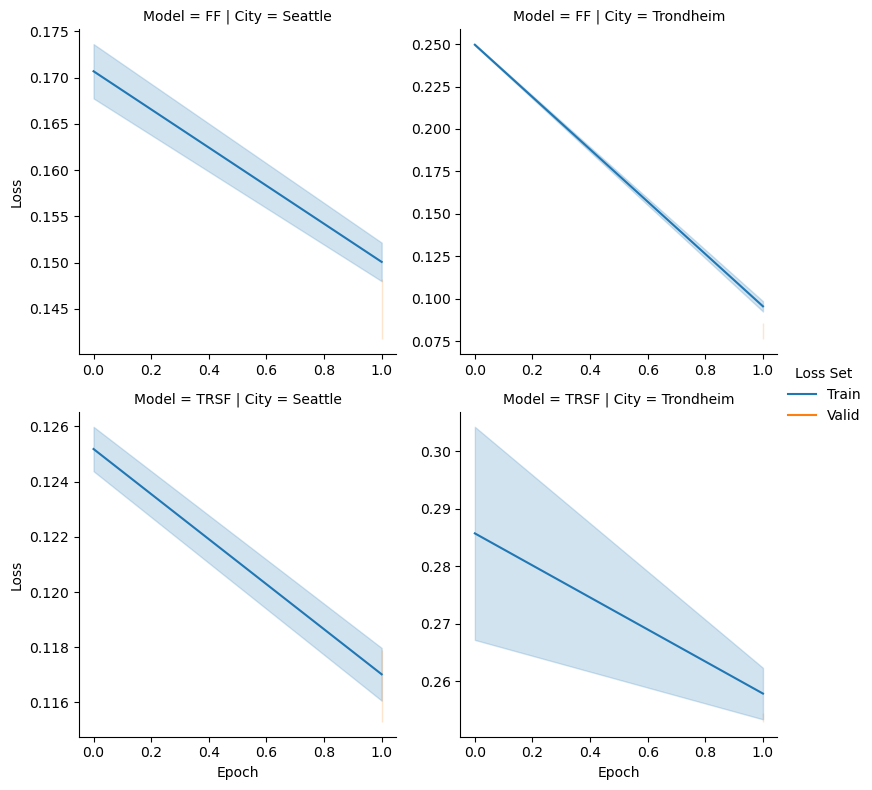

In [54]:
model_list = pd.unique(model_curves_df['Model'])
plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[3:6])]
g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Valid"], height=4, sharex=False, sharey=False)
g.map(sns.lineplot, "Epoch", "Loss")
g.add_legend()
plt.savefig(f"../plots/model_curves_1.png", dpi=1800, bbox_inches='tight')

In [56]:
# model_list = pd.unique(model_curves_df['Model'])
# plot_data = model_curves_df[model_curves_df['Model'].isin(model_list[6:])]
# g = sns.FacetGrid(data=plot_data, col="City", row="Model", hue="Loss Set", hue_order=["Train","Valid"], height=4, sharex=False, sharey=False)
# g.map(sns.lineplot, "Epoch", "Loss")
# g.add_legend()
# plt.savefig(f"../plots/model_curves_1.png", dpi=1800, bbox_inches='tight')

### Generalization (Across Networks)

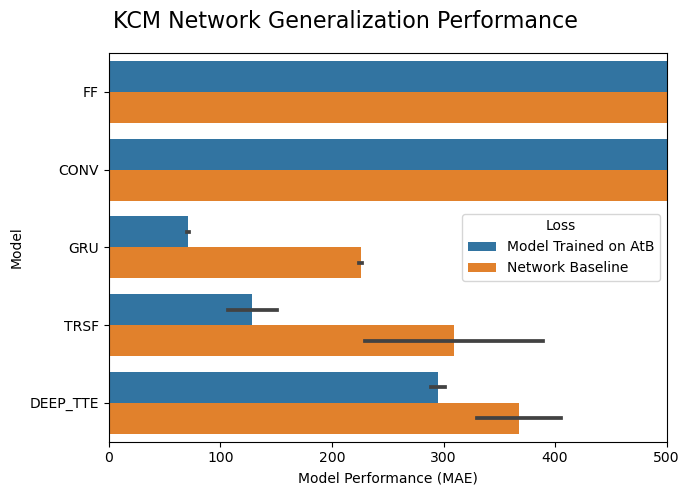

In [61]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Model Trained on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)
sns.barplot(plot_data, x="MAE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 500])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAE)")
fig.suptitle('KCM Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_kcm.png", dpi=1800, bbox_inches='tight')

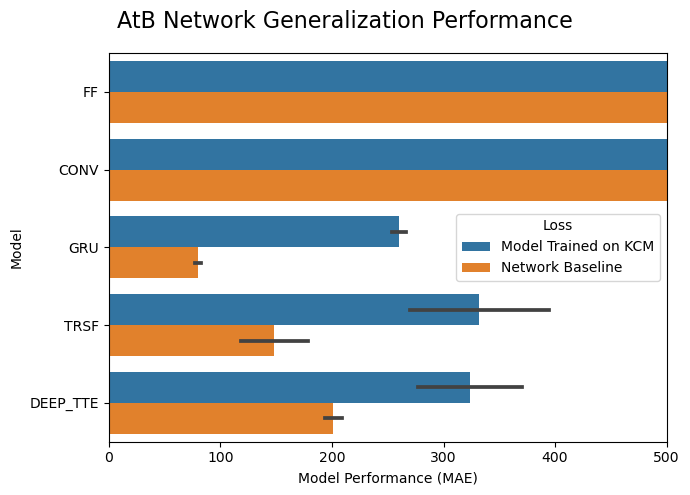

In [64]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Model Trained on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)
sns.barplot(plot_data, x="MAE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 500])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAE)")
fig.suptitle('AtB Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_atb.png", dpi=1800, bbox_inches='tight')

### Generalization (Within Network)

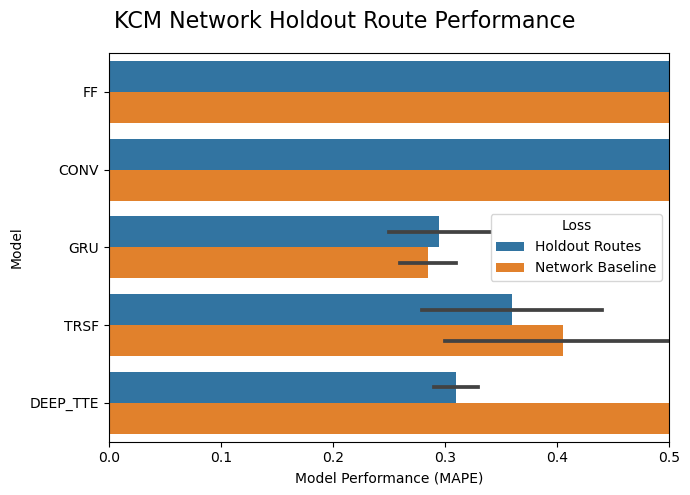

In [70]:
plot_data = kcm_gen_df[kcm_gen_df['Loss']=="Holdout_Losses"].copy()
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data['Loss'] = plot_data['Loss'].replace(["Holdout_Losses"],["Holdout Routes"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 0.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('KCM Network Holdout Route Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_holdout_route_kcm.png", dpi=1800, bbox_inches='tight')

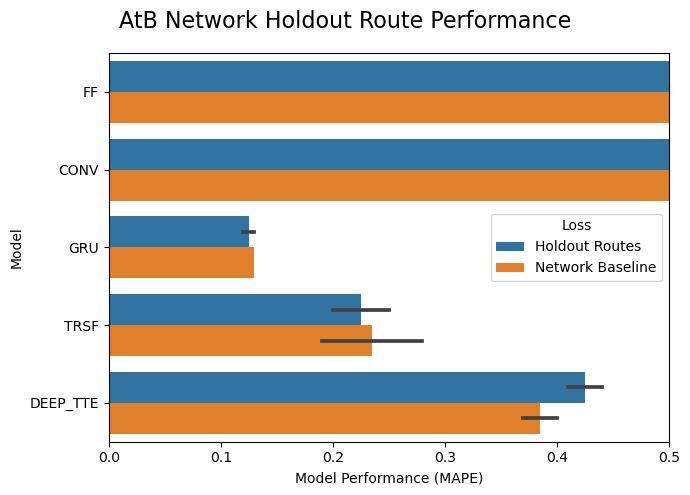

In [71]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Holdout_Losses"].copy()
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data['Loss'] = plot_data['Loss'].replace(["Holdout_Losses"],["Holdout Routes"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)
sns.barplot(plot_data, x="MAPE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 0.5])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAPE)")
fig.suptitle('AtB Network Holdout Route Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_holdout_route_atb.png", dpi=1800, bbox_inches='tight')

### Fine Tuning

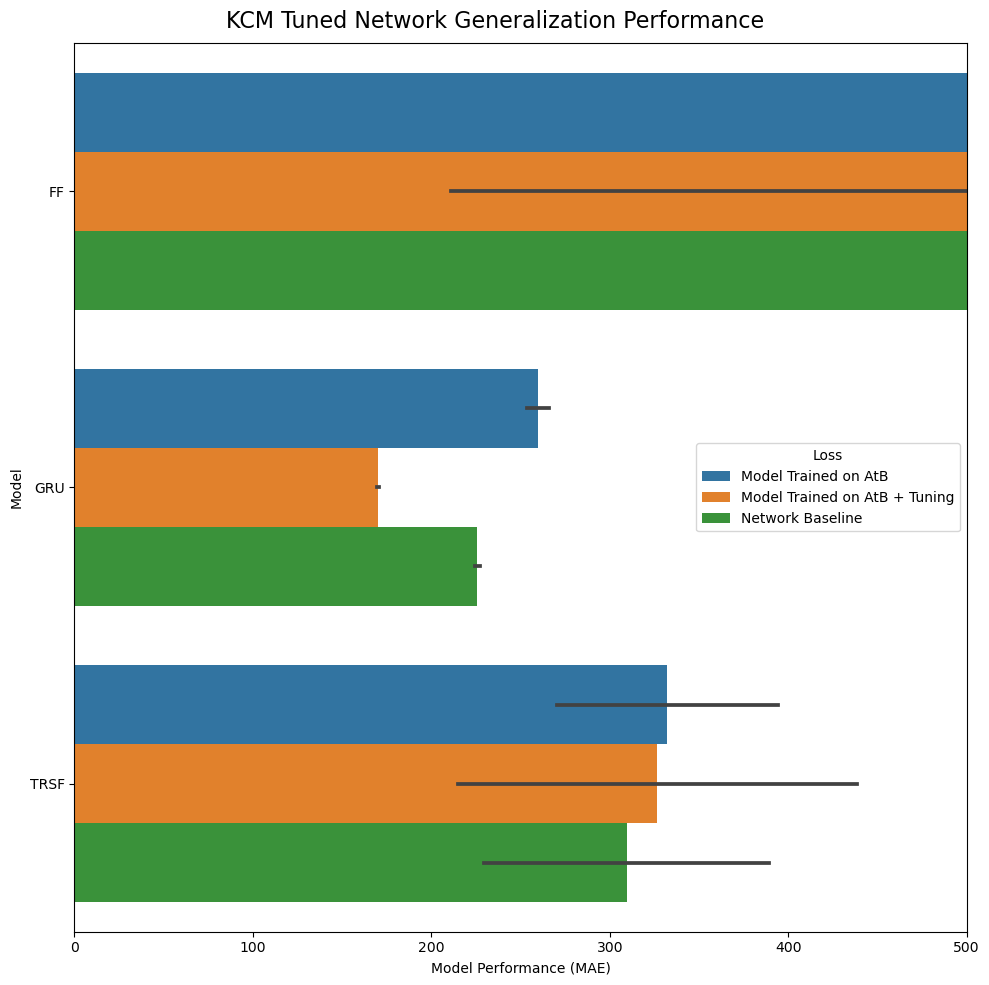

In [73]:
plot_data = kcm_gen_df[kcm_gen_df['Loss'].isin(['Tune_Test_Losses','Test_Losses'])]
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data = plot_data[plot_data['Model'].isin(['AVG','FF','GRU','TRSF'])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses"],["Model Trained on AtB + Tuning", "Model Trained on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.barplot(plot_data, x="MAE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 500])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAE)")
fig.suptitle('KCM Tuned Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_tuning_kcm.png", dpi=1800, bbox_inches='tight')

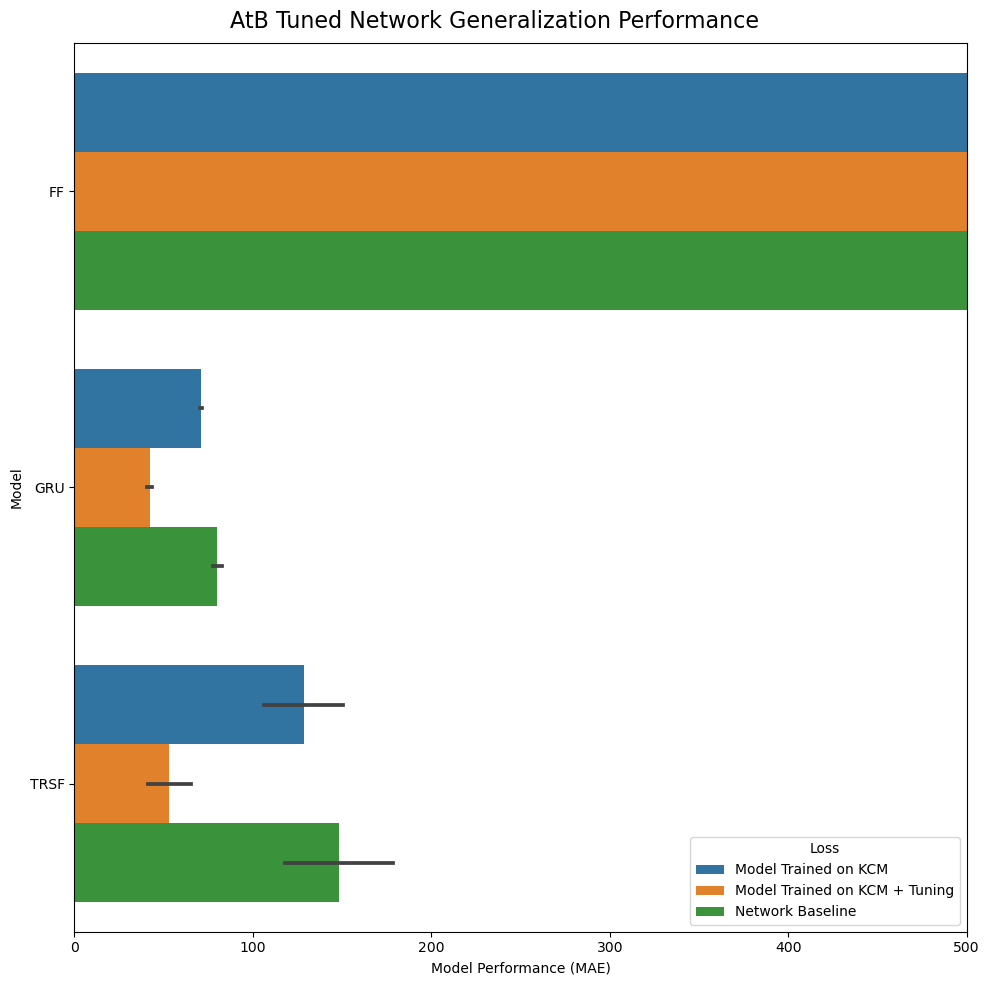

In [74]:
plot_data = atb_gen_df[atb_gen_df['Loss'].isin(['Tune_Test_Losses', 'Test_Losses'])]
plot_data = pd.concat([plot_data, atb_baseline_df])
plot_data = plot_data[plot_data['Model'].isin(['AVG','FF','GRU','TRSF'])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses"],["Model Trained on KCM + Tuning", "Model Trained on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.barplot(plot_data, x="MAE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 500])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAE)")
fig.suptitle('AtB Tuned Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_tuning_atb.png", dpi=1800, bbox_inches='tight')

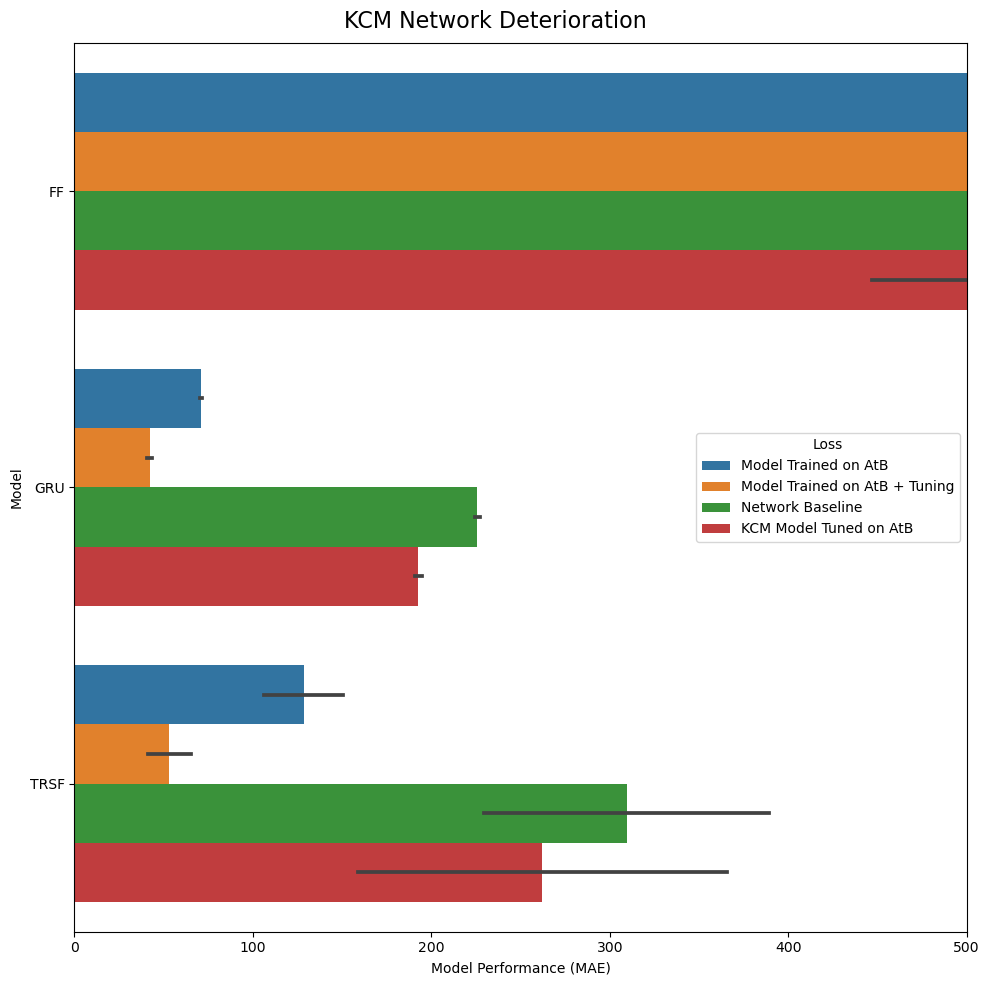

In [77]:
plot_data = atb_gen_df[atb_gen_df['Loss'].isin(['Tune_Test_Losses', 'Test_Losses'])]
plot_data = pd.concat([plot_data, kcm_baseline_df, kcm_deterioration_df])
plot_data = plot_data[plot_data['Model'].isin(['AVG','FF','GRU','TRSF'])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses","Tune_Train_Losses"],["Model Trained on AtB + Tuning", "Model Trained on AtB", "KCM Model Tuned on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.barplot(plot_data, x="MAE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 500])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAE)")
fig.suptitle('KCM Network Deterioration', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_deterioration_kcm.png", dpi=1800, bbox_inches='tight')

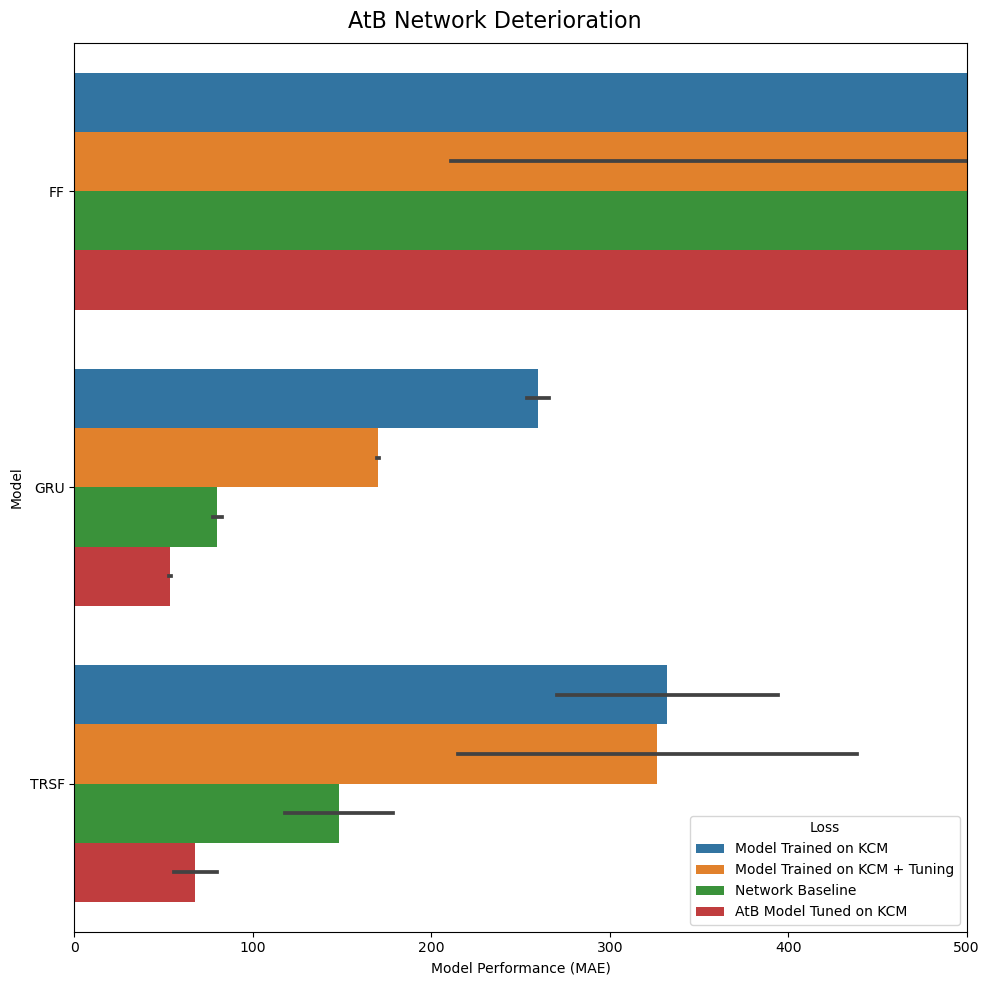

In [79]:
plot_data = kcm_gen_df[kcm_gen_df['Loss'].isin(['Tune_Test_Losses','Test_Losses'])]
plot_data = pd.concat([plot_data, atb_baseline_df, atb_deterioration_df])
plot_data = plot_data[plot_data['Model'].isin(['AVG','FF','GRU','TRSF'])]
plot_data['Loss'] = plot_data['Loss'].replace(["Tune_Test_Losses","Test_Losses","Tune_Train_Losses"],["Model Trained on KCM + Tuning", "Model Trained on KCM", "AtB Model Tuned on KCM"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(10)
fig.set_figwidth(10)
sns.barplot(plot_data, x="MAE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 500])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAE)")
fig.suptitle('AtB Network Deterioration', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_deterioration_atb.png", dpi=1800, bbox_inches='tight')

### Mixed Data

In [ ]:
plot_data = atb_gen_df[atb_gen_df['Loss']=="Test_Losses"].copy()
plot_data = pd.concat([plot_data, kcm_baseline_df])
plot_data['Loss'] = plot_data['Loss'].replace(["Test_Losses"],["Model Trained on AtB"])
fig, axes = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(7)
sns.barplot(plot_data, x="MAE", y="Model", hue="Loss", dodge=True)
axes.set_xlim([0, 500])
axes.set_ylabel("Model")
axes.set_xlabel("Model Performance (MAE)")
fig.suptitle('KCM Network Generalization Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_generalization_kcm.png", dpi=1800, bbox_inches='tight')